# Prediction of Apple's revenue for fiscal year 2018

In [2]:
# Import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

/Users/apple/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Import the dataset

Originally the date is given in string format. If we want to use it as a time series, we should pass to pd.read_csv 
command special arguments. 

1) parse_dates: Specifies the column that contains the date information.

2) index_col: The index has to be the variable depicting date-time information. So here we will use the ‘Date’ column as index.

3) date_parser: This specifies a function which converts the datetime variable in ‘YYYY-MM-DD HH:MM:SS’ format.

In [3]:
dt_parse = lambda dates: pd.datetime.strptime(dates,'%d/%m/%Y')
df = pd.read_csv('Apple_Revenues.csv',parse_dates = ['Date'], index_col = 'Date' , date_parser = dt_parse)
df = df.drop(df.index[-1])
df = df.drop(df.index[0])
print(df.head())

            Revenue(Quarterly)
Date                          
2017-12-31         88290000000
2017-09-30         52580000000
2017-06-30         45410000000
2017-03-31         52900000000
2016-12-31         78350000000


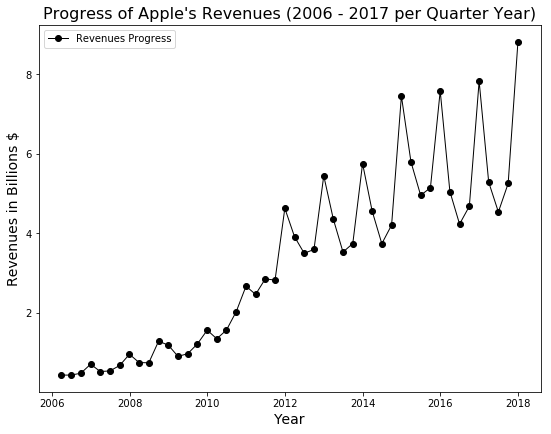

In [4]:
# Make a plot of the data in order to get a view on the progress of the revenues.
plt.figure(figsize = (9, 6.75))
plt.plot(df/1e10, color = 'black', marker='o', linestyle = '-', linewidth = 1, markersize = 6, label = "Revenues Progress")
plt.legend(loc = 'best')
plt.title("Progress of Apple's Revenues (2006 - 2017 per Quarter Year)", fontsize = 16)
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Revenues in Billions $", fontsize = 14)
plt.show()

Comments from the plot

By looking at the revenue profile, it is evident that there is an overall increasing trend on the revenue. 
It is also clear that there are some seasonal variations.

/Users/apple/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).mean()
/Users/apple/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).std()


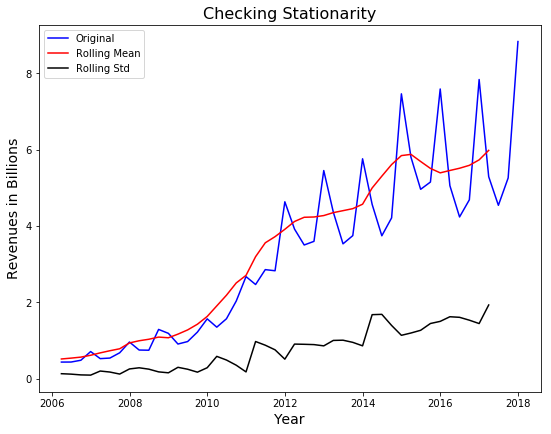

Results of Dickey-Fuller Test:
Test Statistic                 -0.754151
p-value                         0.832221
#Lags Used                      4.000000
Number of Observations Used    43.000000
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
Critical Value (10%)           -2.604066
dtype: float64


In [5]:
# The next step is to check the stationarity of the data using a Dickey-Fuller test.

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window = 4)
    rolstd = pd.rolling_std(timeseries, window = 4)

    #Plot rolling statistics:
    fig = plt.figure(figsize = (9, 6.75))
    orig = plt.plot(timeseries, color = 'blue',label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Checking Stationarity',fontsize = 16)
    plt.ylabel("Revenues in Billions", fontsize = 14)
    plt.xlabel("Year", fontsize = 14)
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
test_stationarity(df["Revenue(Quarterly)"]/1.e10)

Comments from the stationarity test.

From the plot we see that the standard deviation has an increasing profile, thus this timeseries cannot ve considered 
as stationary. Thus, some techniques should be applied for making the dataseries stationary.

The two main reasons that a series is not stationary are: trend (i.e., having a varying mean) and seasonality (i.e., it is clear that there is a significant jump on the revenues on the 4th quarter of each year, most likely due to Christmas season).

In [6]:
# Make estimates and Eliminate trend.
# Transformations is the first approach to reduce the positive trend that the data have. We can start by scaling the 
# data by taking a log transformation.
df_log = np.log(df)

In [7]:
# Moving average
# Here we will take "k" consecutive values depending on the frequency of the time series. For this case k = 4.
moving_aver = pd.rolling_mean(df_log, 4)

/Users/apple/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=4,center=False).mean()
  app.launch_new_instance()


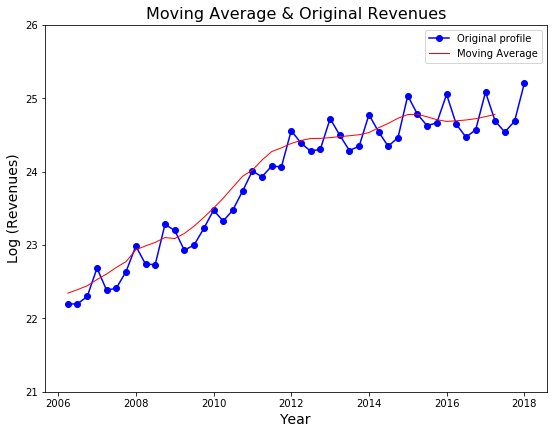

In [8]:
# Overplot the original timeseries together with the moving average profile 
plt.figure(figsize = (9, 6.75))
plt.plot(df_log, color = 'blue', marker='o', linestyle = '-', linewidth = 1.5, markersize = 6, label = "Original profile")
plt.plot(moving_aver, color = 'red', linestyle = '-', linewidth = 1, label = "Moving Average")
plt.legend(loc = 'best')
plt.title("Moving Average & Original Revenues", fontsize = 16)
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Log (Revenues)", fontsize = 14)
plt.ylim(21,26)
plt.show()

/Users/apple/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).mean()
/Users/apple/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).std()


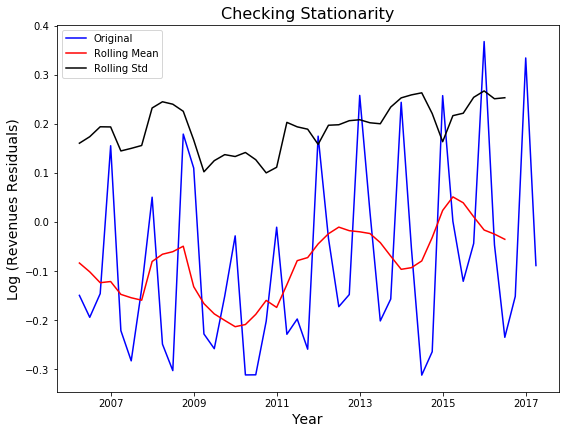

Results of Dickey-Fuller Test:
Test Statistic                 -2.157483
p-value                         0.222037
#Lags Used                      4.000000
Number of Observations Used    40.000000
Critical Value (1%)            -3.605565
Critical Value (5%)            -2.937069
Critical Value (10%)           -2.606986
dtype: float64


In [9]:
# We can now subtract the rolling mean from the original timeseries. Note that since rolling mean is created by 
# averaging 4 values, it is not defined for the first four values.
diff_moving_aver = df_log - moving_aver

# Remove the missing values (i.e., the self-generated NANs)
diff_moving_aver.dropna(inplace = True)


# Check again the stationarity

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window = 4)
    rolstd = pd.rolling_std(timeseries, window = 4)

    #Plot rolling statistics:
    fig = plt.figure(figsize = (9, 6.75))
    orig = plt.plot(timeseries, color = 'blue',label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Checking Stationarity',fontsize = 16)
    plt.ylabel("Log (Revenues Residuals)", fontsize = 14)
    plt.xlabel("Year", fontsize = 14)
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# Check again the stationarity
test_stationarity(diff_moving_aver["Revenue(Quarterly)"])

The p-value is very high, thus again we cannot consider the timeseries stationary.


Exponentially weighted moving average

A different approach is to use a weighted moving average, where more recent values are assigned with a higher weight. In the case of exponentially weighted moving average, the weights are assigned to all the previous values with a decay factor.

/Users/apple/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=4,min_periods=0,adjust=True,ignore_na=False).mean()
  if __name__ == '__main__':


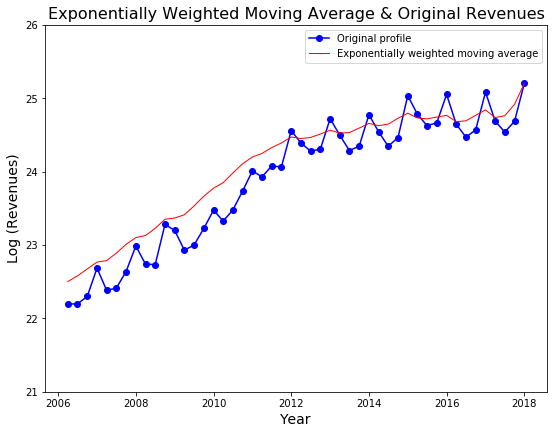

/Users/apple/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).mean()
/Users/apple/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).std()


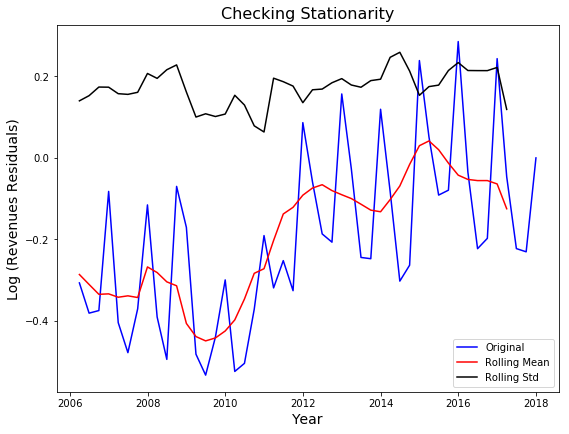

Results of Dickey-Fuller Test:
Test Statistic                 -1.529673
p-value                         0.518785
#Lags Used                      4.000000
Number of Observations Used    43.000000
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
Critical Value (10%)           -2.604066
dtype: float64


In [10]:
EWMA = pd.ewma(df_log, 4)


# Overplot the original timeseries together with the exponentially weighted moving average profile 
plt.figure(figsize = (9, 6.75))
plt.plot(df_log, color = 'blue', marker='o', linestyle = '-', linewidth = 1.5, markersize = 6, label = "Original profile")
plt.plot(EWMA, color = 'red', linestyle = '-', linewidth = 1, label = "Exponentially weighted moving average")
plt.legend(loc = 'best')
plt.title("Exponentially Weighted Moving Average & Original Revenues", fontsize = 16)
plt.ylabel("Log (Revenues)", fontsize = 14)
plt.xlabel("Year", fontsize = 14)
plt.ylim(21,26)
plt.show()
           
# Check against the stationarity of the series
EWMA_diff = df_log - EWMA
test_stationarity(EWMA_diff["Revenue(Quarterly)"])

Even though the p-value is reduced significantly, but it is still too high to state that the timeseries is stationary.

 Eliminate trend and seasonality

Since the trend reduction techniques we used just above didn’t give a satisfactory result ( due to seasonality) we can apply two different ways to remove the trend and seasonality. These are:

1) Differencing: The differece with a particular time lag
2) Decomposition:  Modeling both trend and seasonality and removing them from the model.

In [11]:
# Differencing
# Take the log difference
df_log_diff = df_log - df_log.shift()

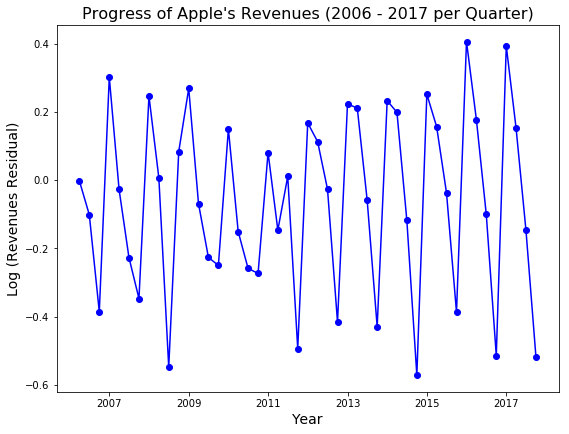

/Users/apple/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).mean()
/Users/apple/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).std()


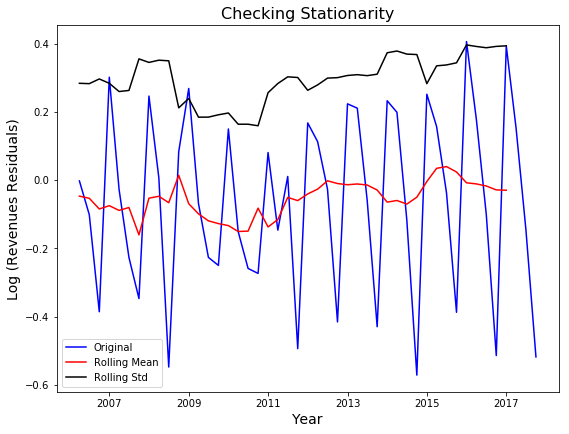

Results of Dickey-Fuller Test:
Test Statistic                 -2.355204
p-value                         0.154781
#Lags Used                      3.000000
Number of Observations Used    43.000000
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
Critical Value (10%)           -2.604066
dtype: float64


In [12]:
# Plot the data
plt.figure(figsize = (9, 6.75))
plt.plot(df_log_diff, color = 'blue', marker='o', linestyle = '-', linewidth = 1.5, markersize = 6, label = "Original profile")
plt.title("Progress of Apple's Revenues (2006 - 2017 per Quarter)", fontsize = 16)
plt.ylabel("Log (Revenues Residual)", fontsize = 14)
plt.xlabel("Year", fontsize = 14)
plt.show()   

df_log_diff.dropna(inplace = True)
test_stationarity(df_log_diff["Revenue(Quarterly)"])

The p-value is very high, thus again we cannot state that the timeseries in stationary.

/Users/apple/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).mean()
/Users/apple/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).std()


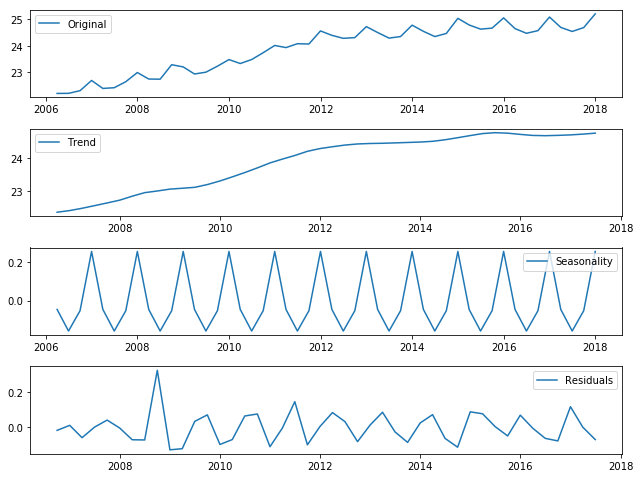

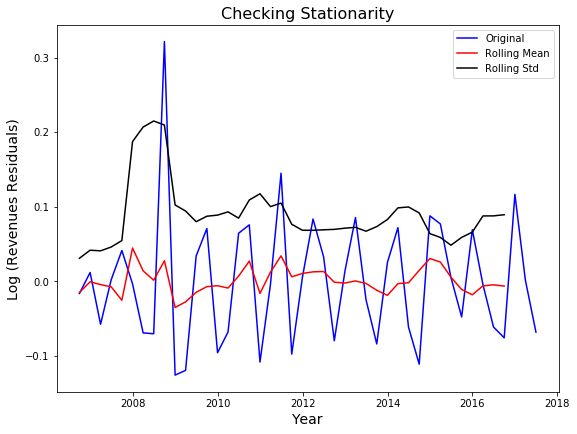

Results of Dickey-Fuller Test:
Test Statistic                -7.921714e+00
p-value                        3.709101e-12
#Lags Used                     2.000000e+00
Number of Observations Used    4.100000e+01
Critical Value (1%)           -3.600983e+00
Critical Value (5%)           -2.935135e+00
Critical Value (10%)          -2.605963e+00
dtype: float64


In [13]:
# Decomposition
decomposition = seasonal_decompose(df_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize = (9, 6.75))
plt.subplot(411)
plt.plot(df_log,label = "Original")
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend,label = "Trend")
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label = "Seasonality")
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual,label = "Residuals")
plt.legend(loc='best')
plt.tight_layout()

df_log_decompose = residual
df_log_decompose.dropna(inplace = True)
test_stationarity(df_log_decompose["Revenue(Quarterly)"])

This the lowest p-value so far and since p-value << than 0.05 we can safely state that the timeseries stationary.

Forescasting a time series

For the forecasting predictions we will apply a specific algorithm known as: ARIMA (Auto-Regressive Integrated Moving 
Averages). The predictors depend on the parameters (p,d,q) of the ARIMA model:

1) Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For example if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

                                 
2) Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For example if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

3) Number of Differences (d): These are the number of nonseasonal differences. So either we can pass that variable and put d = 0 or pass the original variable and put d = 1. Both will generate same results.

In [14]:
# ACF & PACF plots
df_acf = acf(df_log_diff, nlags = 20)
df_pacf = pacf(df_log_diff, nlags = 20, method = 'ols')
plt.figure(figsize = (7, 4.5))

# Plot ACF
plt.subplot(121)
plt.plot(df_acf)
plt.axhline(y = 0,linestyle = '--',color = 'black')
plt.axhline(y = -1.96/np.sqrt(len(df_log_decompose)),linestyle = '--',color = 'green')
plt.axhline(y = 1.96/np.sqrt(len(df_log_decompose)),linestyle = '--',color = 'green')
plt.title('Autocorrelation Function',fontsize=14)


# Plot ACF
plt.subplot(122)
plt.plot(df_pacf)
plt.axhline(y = 0,linestyle = '--',color = 'black')
plt.axhline(y = -1.96/np.sqrt(len(df_log_decompose)),linestyle = '--',color = 'green')
plt.axhline(y = 1.96/np.sqrt(len(df_log_decompose)),linestyle = '--',color = 'green')
plt.title('Partial Autocorrelation Function',fontsize=14)
plt.tight_layout()

/Users/apple/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/apple/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/apple/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


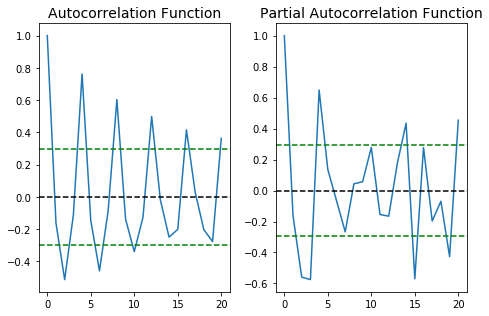

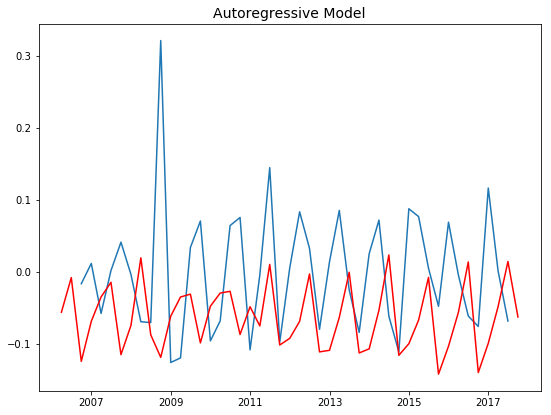

The residual sum of squares for the AR model is: 0.6372813207227854


In [15]:
# AR model
ar_model = ARIMA(df_log, order = (1,1,0))
ar_results = ar_model.fit(disp = -1)
plt.figure(figsize = (9, 6.75))
plt.plot(df_log_decompose)
plt.plot(ar_results.fittedvalues, color='red')
plt.title("Autoregressive Model",fontsize=14)
plt.show()

# Get the RSS for the Auto-Regressive model
ar = ar_results.fittedvalues-df_log_decompose["Revenue(Quarterly)"]
ar.dropna(inplace = True)
ar_rss = sum(ar**2)
print("The residual sum of squares for the AR model is:", ar_rss)

/Users/apple/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/apple/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/apple/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


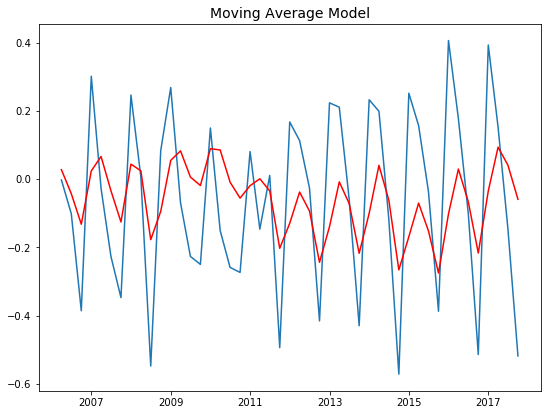

The residual sum of squares for the MA model is: 0.8942492811798031


In [16]:
# MA model
ma_model = ARIMA(df_log, order = (0, 1, 2))
ma_results = ma_model.fit(disp = -1)
plt.figure(figsize = (9, 6.75))
plt.plot(df_log_diff)
plt.plot(ma_results.fittedvalues, color = 'red')
plt.title("Moving Average Model",fontsize=14)
plt.show()

# Get the RSS for the Moving Average model
ma = ma_results.fittedvalues-df_log_decompose["Revenue(Quarterly)"]
ma.dropna(inplace = True)
ma_rss = sum(ma**2)
print("The residual sum of squares for the MA model is:", ma_rss)

/Users/apple/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/apple/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/apple/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


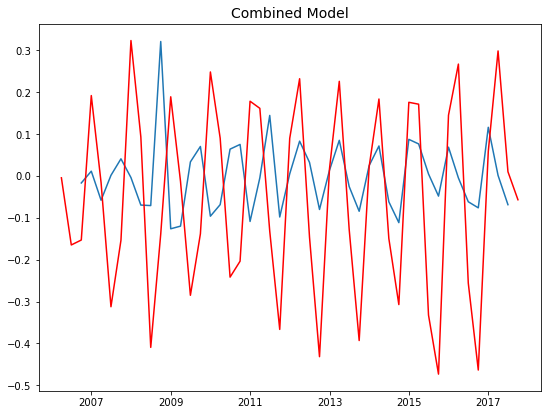

The residual sum of squares for the CM model is: 2.526538217979581


In [17]:
# Combined model
CM_model = ARIMA(df_log, order = (2, 1, 2))
CM_results = CM_model.fit(disp = -1)
plt.figure(figsize = (9, 6.75))
plt.plot(df_log_decompose)
plt.plot(CM_results.fittedvalues, color = 'red')
plt.title("Combined Model",fontsize=14)
plt.show()

# Get the RSS for the Combined model
CM = CM_results.fittedvalues-df_log_decompose["Revenue(Quarterly)"]
CM.dropna(inplace = True)
cm_rss = sum(CM**2)
print("The residual sum of squares for the CM model is:", cm_rss)

In [18]:
# Revenue Predictions for 2018
# For the final predictions we will select the AR model since we got the lowest RSS.
# This will be done by using the forecast() function
future_quarters = ar_results.forecast(steps = 5)[0] # Make sure to include the [0] index so you will get the forecast value
amount = [np.exp(i) for i in future_quarters]

# Therefore we can calculate the prediction for each quarter of 2018
# Note that we are starting from [1] index as [0] corresponds to the one that we already have(Dec. of 2017)

rev_2018_Q1 = amount[1] + df["Revenue(Quarterly)"][1]
rev_2018_Q2 = amount[2] + rev_2018_Q1
rev_2018_Q3 = amount[3] + rev_2018_Q2
rev_2018_Q4 = amount[4] + rev_2018_Q3

In [19]:
print('The revenues of Apple for the first quarter of 2018 are:' + 
      str(rev_2018_Q1)[0:2] +'.' + str(rev_2018_Q1)[2:4] +' Billion dollars')                 
                 
print('The revenues of Apple for the second quarter of 2018 are:' + 
      str(rev_2018_Q2)[0:2] +'.' + str(rev_2018_Q2)[2:4] +' Billion dollars') 

print('The revenues of Apple for the third quarter of 2018 are:' + 
      str(rev_2018_Q3)[0:2] +'.' + str(rev_2018_Q3)[2:4] +' Billion dollars') 

print('The revenues of Apple for the fourth quarter of 2018 are:' + 
      str(rev_2018_Q4)[0:2] +'.' + str(rev_2018_Q4)[2:4] +' Billion dollars') 

# Total Revenue of Apple for Fiscal year 2018
tot_rev_2018 = rev_2018_Q1 + rev_2018_Q2 + rev_2018_Q3 + rev_2018_Q4

print('Our prediction for Apple\'s revenues for the fiscal year 2018 is: ' +
      str(tot_rev_2018)[0:3] +'.'+ str(tot_rev_2018)[3:5]+' Billion dollars')

The revenues of Apple for the first quarter of 2018 are:56.39 Billion dollars
The revenues of Apple for the second quarter of 2018 are:59.97 Billion dollars
The revenues of Apple for the third quarter of 2018 are:63.33 Billion dollars
The revenues of Apple for the fourth quarter of 2018 are:66.48 Billion dollars
Our prediction for Apple's revenues for the fiscal year 2018 is: 246.18 Billion dollars


Our revenues prediction for the first quarter of 2018 is 56.39 billions. If we compare our findings with the value that is given for the actual revenues (61.14 billions), we see that our value is in good agreement (92.23%). 